# Description

This notebook explores ways to calculate share of remote work for each user in each month when their home and work location are known. As all data is big, only users that we meet at least 6 months in the dataset are included

In [2]:
import os
import geopandas as gpd
import pandas as pd
import argparse
from geofunctions import utils

## Read files

In [3]:
df_freq_ident = pd.read_csv(
    utils.get_path("processed", "dwells", "samples/identifiers_12m_freq.csv"), index_col=0
)

In [4]:
freq_users_list = df_freq_ident["identifier"].values

In [5]:
months = ['201901','201904','201907','201908','201909','201911','201912','202309']#utils.return_list_months_ok()

In [6]:
# Read files

list_months = []
for MONTH in months:
    print(MONTH)
    df_filtered_good = pd.read_parquet(
        utils.get_path("raw", "dwells", f"data_filtered_{MONTH}.parquet")
    )
    df_filtered_freq = df_filtered_good#[
    #     df_filtered_good.identifier.isin(freq_users_list)
    # ]
    if len(df_filtered_freq) > 0:
        df_filtered_dwells = utils.make_gdf(df_filtered_freq, geometry="the_geom")
        df_filtered_dwells["month"] = MONTH
        list_months.append(df_filtered_dwells)

201901
Parsed WKB to geometry
201904
Parsed WKB to geometry
201907
Parsed WKB to geometry
201908
Parsed WKB to geometry
201909
Parsed WKB to geometry
201911
Parsed WKB to geometry
201912
Parsed WKB to geometry
202309
Parsed WKB to geometry


In [7]:
df_filtered_dwells = pd.concat(list_months)

In [8]:
df_filtered_dwells.shape

(4046807, 22)

In [10]:
list_freq_ident_df = []
for MONTH in months:

    work_df_part = pd.read_csv(
        os.path.join(
            utils.get_path("processed", "dwells", "work"),
            f"users_work_home_{MONTH}.csv",
        ),
        index_col=0,
    )
    freq_df = work_df_part#[work_df_part.identifier.isin(freq_users_list)]
    freq_df["month"] = MONTH
    list_freq_ident_df.append(freq_df)

In [60]:
months

['201901',
 '201904',
 '201907',
 '201908',
 '201909',
 '201911',
 '201912',
 '202309']

In [11]:
df_freq_home_work = pd.concat(list_freq_ident_df)

In [12]:
df_freq_home_work = df_freq_home_work.drop_duplicates(["identifier", "month"])

## Add home/work location flags to dwells dataset

In [13]:
df_freq_full_home_work = df_filtered_dwells.merge(
    df_freq_home_work[["identifier", "geohash_home", "geohash_work", "month"]],
    on=["identifier", "month"],
)

In [14]:
df_freq_full_home_work.shape

(1738616, 24)

In [15]:
df_freq_full_home_work["geometry_work"] = df_freq_full_home_work["geohash_work"].apply(
    utils.geohash_to_polygon
)
df_freq_full_home_work["distance_work"] = utils.calculate_distance(
    df_freq_full_home_work, "geometry_work", "the_geom", crs=4326
)

df_freq_full_home_work["flag_work_geohash"] = (
    df_freq_full_home_work["distance_work"] <= 250
)

In [16]:
df_freq_full_home_work["geometry_home"] = df_freq_full_home_work["geohash_home"].apply(
    utils.geohash_to_polygon
)
df_freq_full_home_work["distance_home"] = utils.calculate_distance(
    df_freq_full_home_work, "geometry_home", "the_geom", crs=4326
)

df_freq_full_home_work["flag_home_geohash"] = (
    df_freq_full_home_work["distance_home"] <= 250
)

In [17]:
df_freq_full_home_work["flag_type_loc_new"] = df_freq_full_home_work[
    ["flag_home_geohash", "flag_work_geohash"]
].apply(
    lambda r: (
        "home"
        if r["flag_home_geohash"]
        else ("work" if r["flag_work_geohash"] else "other")
    ),
    axis=1,
)

In [18]:
df_freq_only_homework = df_freq_full_home_work[
    df_freq_full_home_work["flag_type_loc_new"].isin(["home", "work"])
]

In [19]:
df_freq_only_homework.shape

(1042572, 31)

In [ ]:
df_freq_only_homework

In [20]:
# explode dwells to hourly signals
df_freq_only_homework["hours_in_interval"] = df_freq_only_homework.apply(
    lambda row: pd.date_range(
        start=row["start_date_time"].floor("h"),
        end=row["end_date_time"].ceil("h") - pd.Timedelta(hours=1),
        freq="h",
    ).tolist(),
    axis=1,
)

# Explode the hours into separate rows
df_hours = df_freq_only_homework.explode("hours_in_interval")
df_hours["hour"] = df_hours["hours_in_interval"].dt.hour

In [47]:
df_hours.columns

Index(['identifier', 'identifier_type', 'timestamp', 'local_date_time',
       'province', 'classification', 'duration_seconds', 'centroid_latitude',
       'centroid_longitude', 'bump_count', 'potential_start_time',
       'potential_end_time', 'month', 'the_geom', 'frequency',
       'duration_hours', 'geohash', 'date', 'start_date_time', 'end_date_time',
       'flag_night', 'flag_work_hours', 'geohash_home', 'geohash_work',
       'geometry_work', 'distance_work', 'flag_work_geohash', 'geometry_home',
       'distance_home', 'flag_home_geohash', 'flag_type_loc_new',
       'hours_in_interval', 'hour'],
      dtype='object')

## Add day type weekend or not

In [21]:

import holidays

# Define Israeli holidays
israel_holidays = holidays.Israel()

# Ensure 'date' is in datetime format first
df_hours["date"] = pd.to_datetime(df_hours["date"])

# Create the 'flag_weekend' column
df_hours["flag_weekend"] = (
    df_hours["date"].dt.weekday.isin([4, 5]) |  # Check if Friday or Saturday
    df_hours["date"].dt.date.isin(israel_holidays)  # Check if it's an Israeli holiday
)

## Add day type by user:
1. work from office - there is a signal from office

In [22]:
df_hours["work_location_hours"] = df_hours.groupby(["date", "identifier"])[
    "flag_work_geohash"
].transform("sum")

In [23]:
df_hours["office_day"] = df_hours["work_location_hours"] > 0

In [24]:
df_hours["office_day"].value_counts()

office_day
False    1257738
True     1053982
Name: count, dtype: int64

### Remove duplicates caused by consequent dwells, one of which starts and another one ends at the same hour

In [25]:
df_hours.drop_duplicates(["identifier", "hour", "date"]).shape

(2172518, 36)

In [54]:
df_hours.shape

(22704, 36)

In [26]:
df_hours = df_hours.drop_duplicates(["identifier", "hour", "date"])

# Lets explore hours frequency when people work from office

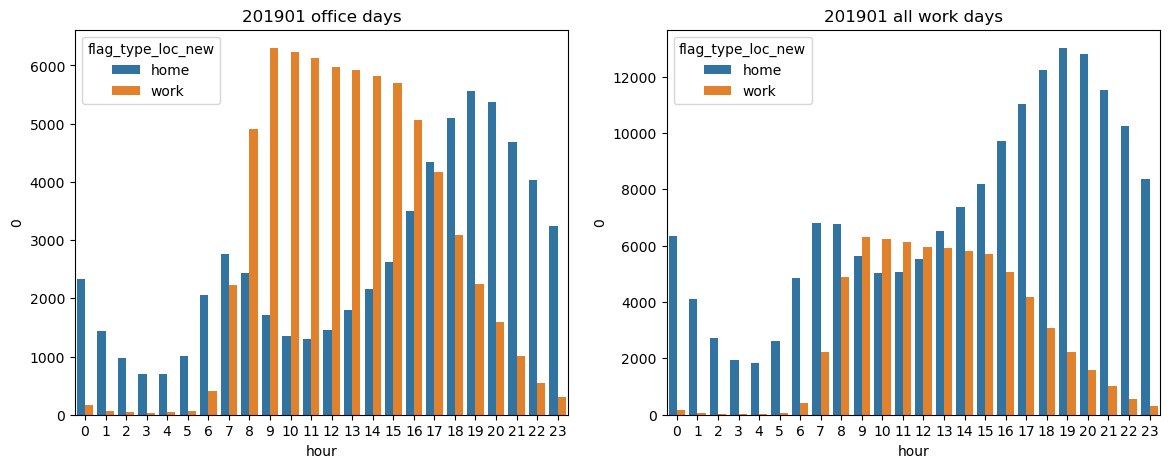

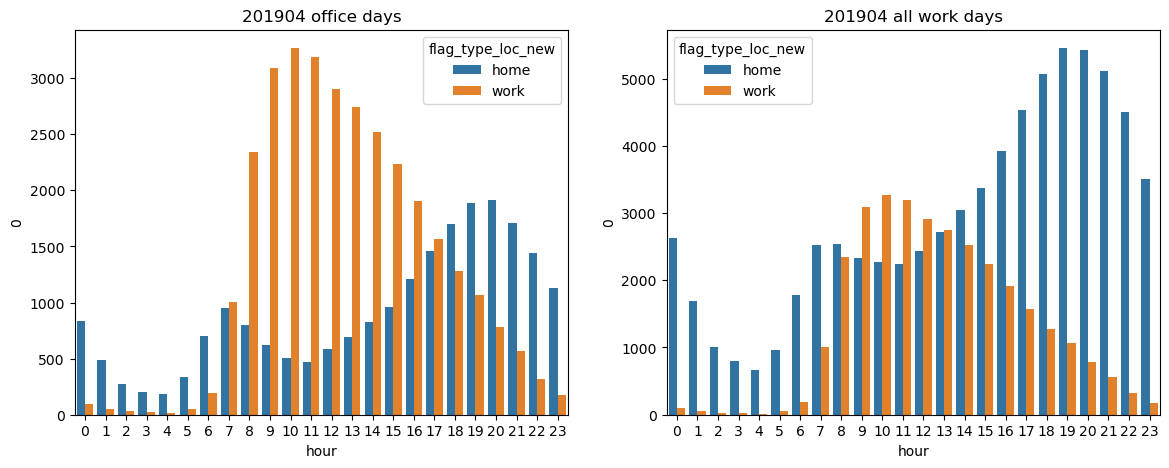

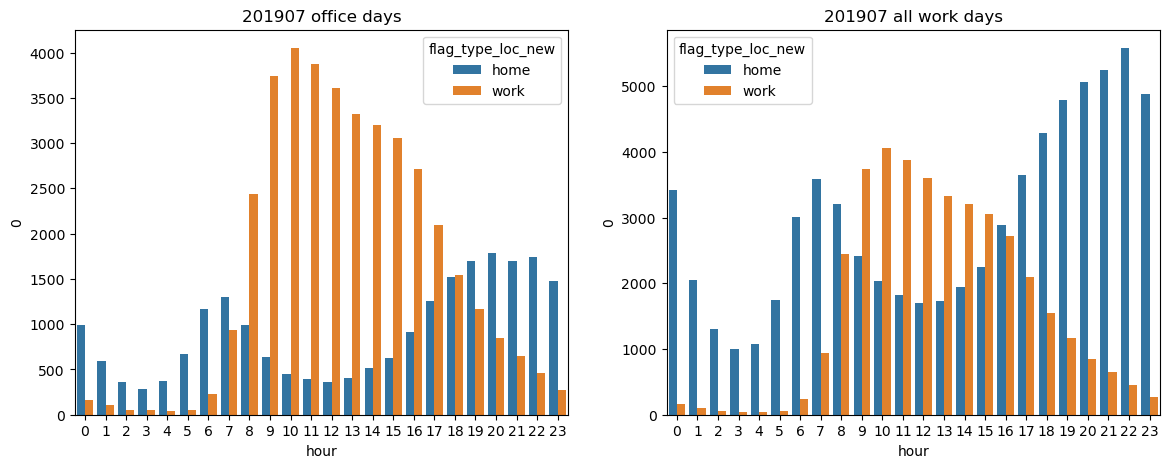

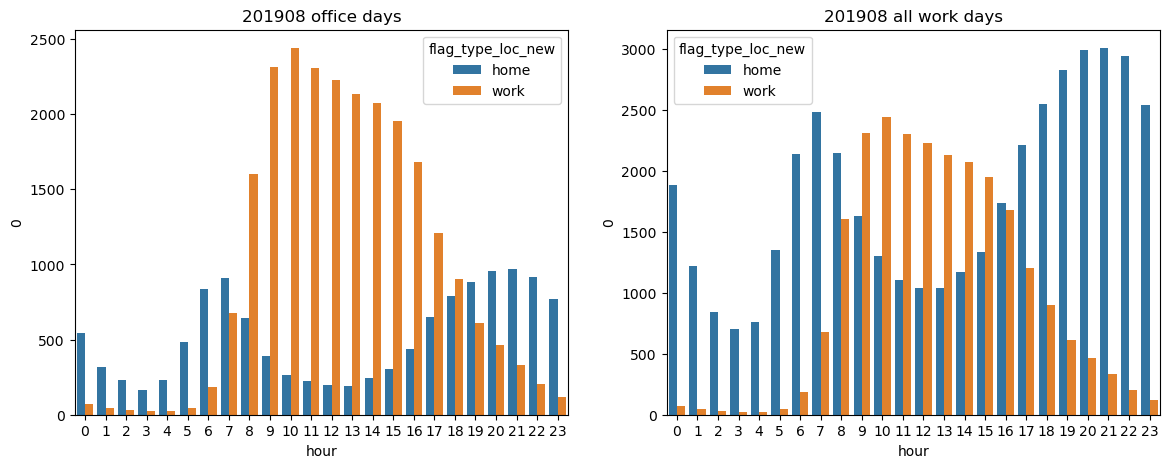

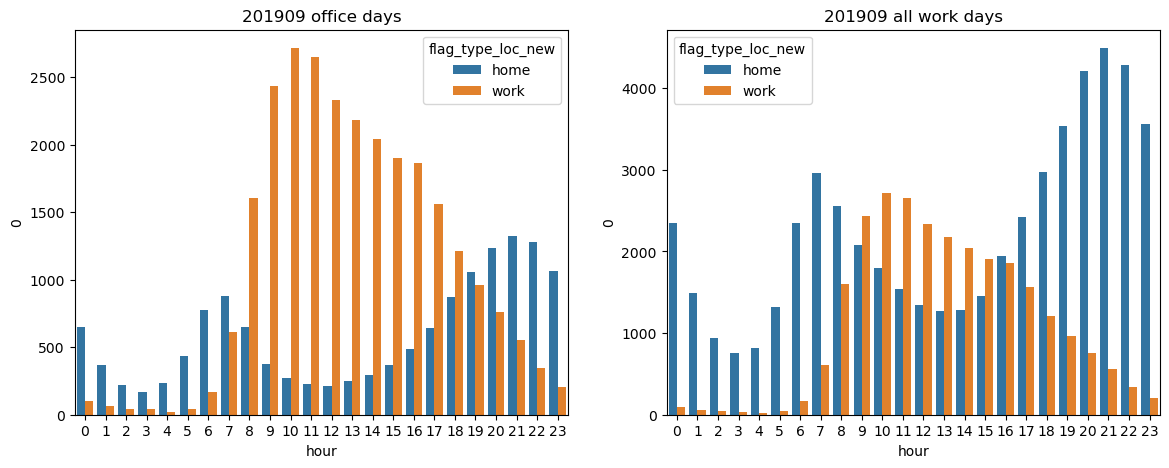

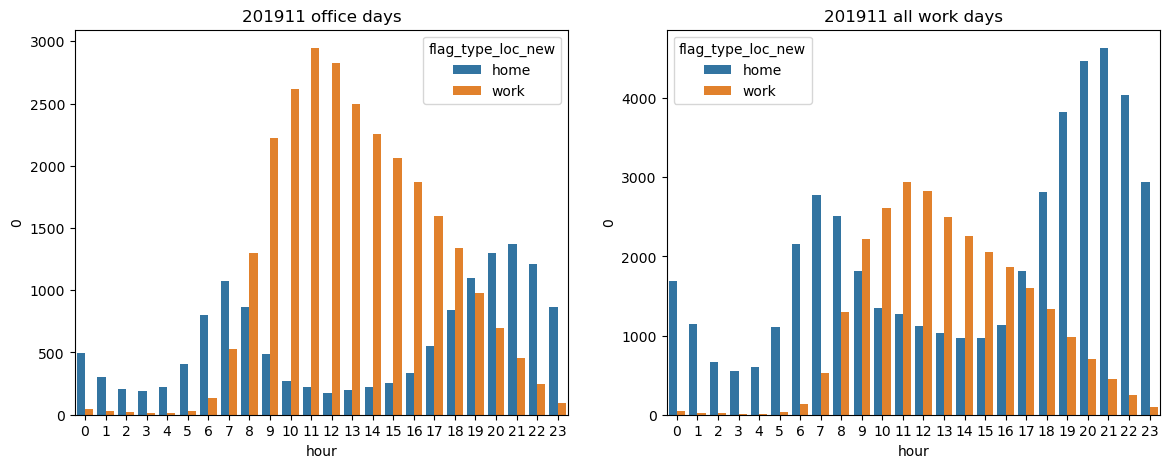

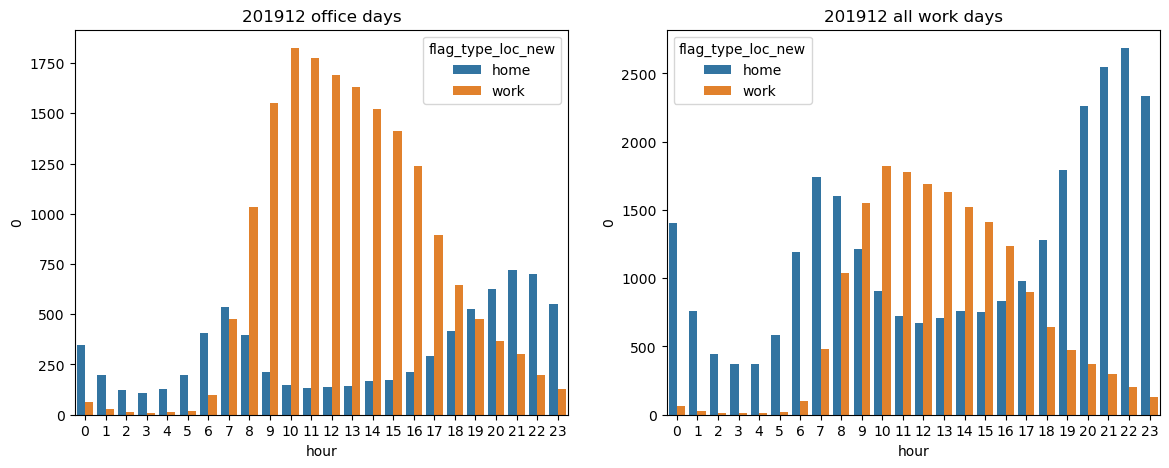

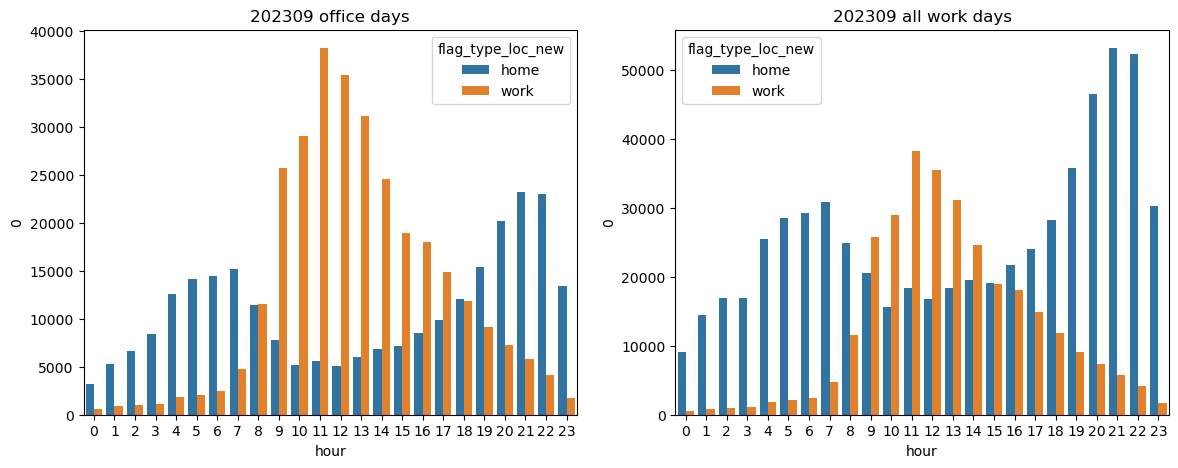

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn

for MONTH in months:
    df_month_loc_hours_office = (
        df_hours[
            (df_hours.month == MONTH)
            & (df_hours["office_day"])
            & (~df_hours.flag_weekend)
        ]
        .groupby(["hour", "flag_type_loc_new"])
        .size()
        .reset_index()
    )
    df_month_loc_hours = (
        df_hours[(df_hours.month == MONTH) & (~df_hours.flag_weekend)]
        .groupby(["hour", "flag_type_loc_new"])
        .size()
        .reset_index()
    )
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    sn.barplot(
        data=df_month_loc_hours_office,
        x="hour",
        y=0,
        hue="flag_type_loc_new",
        ax=axs[0],
    )
    axs[1].set_title(f"{MONTH} all work days")
    sn.barplot(
        data=df_month_loc_hours, x="hour", y=0, hue="flag_type_loc_new", ax=axs[1]
    )
    axs[0].set_title(f"{MONTH} office days")
    plt.show()

In [30]:
df_hours.groupby('month')['identifier_type'].value_counts(normalize=True)

month   identifier_type
201901  IDFA               0.800267
        GAID               0.199733
201904  IDFA               0.692851
        GAID               0.307149
201907  GAID               0.711415
        IDFA               0.288585
201908  GAID               0.907704
        IDFA               0.092296
201909  GAID               0.779858
        IDFA               0.220142
201911  GAID               0.727601
        IDFA               0.272399
201912  GAID               0.744382
        IDFA               0.255618
202309  GAID               0.841137
        IDFA               0.158863
Name: proportion, dtype: float64

In [31]:
df_hours.groupby(['month','identifier','identifier_type']).size().groupby(['month','identifier_type']).mean()

month   identifier_type
201901  GAID                54.152542
        IDFA               114.243776
201904  GAID                40.425963
        IDFA                75.876793
201907  GAID                52.402815
        IDFA                46.629454
201908  GAID                52.853982
        IDFA                35.722689
201909  GAID                51.628408
        IDFA                45.242126
201911  GAID                45.870312
        IDFA                47.225524
201912  GAID                41.813360
        IDFA                41.290960
202309  GAID                49.342188
        IDFA                50.358103
dtype: float64

In [38]:
df_hours.gropby(['month','identifier','identifier_type'])['flag_type_loc_new'].value_counts(normalize=True).groupby(['month','identifier_type','flag_type_loc_new']).mean()

month   identifier_type  flag_type_loc_new
201901  GAID             home                 0.694246
                         work                 0.306027
        IDFA             home                 0.775270
                         work                 0.224836
201904  GAID             home                 0.674623
                         work                 0.325377
        IDFA             home                 0.757741
                         work                 0.242259
201907  GAID             home                 0.685468
                         work                 0.314532
        IDFA             home                 0.714480
                         work                 0.286369
201908  GAID             home                 0.710575
                         work                 0.289425
        IDFA             home                 0.701901
                         work                 0.298099
201909  GAID             home                 0.718644
                      

In [32]:
df_hours.groupby(['month','identifier','identifier_type']).size().groupby(['month','identifier_type']).count()

month   identifier_type
201901  GAID                1121
        IDFA                2129
201904  GAID                 986
        IDFA                1185
201907  GAID                1847
        IDFA                 842
201908  GAID                1582
        IDFA                 238
201909  GAID                1577
        IDFA                 508
201911  GAID                1573
        IDFA                 572
201912  GAID                1018
        IDFA                 354
202309  GAID               21307
        IDFA                3943
dtype: int64

In [ ]:
# Office day distribution of dwells for each user - is expected behavior when there is no WFH
# In the day where office hours are absent there are two options: no signals in work hours at all or he worked remotely

First we explore why some people have afternoon signals at home before covid. Apparently they have work shifts that dont match standart working hours

## Conditional probability to be at home location in specific hour
* P(A/B) = (P(A)*P(B/A))/P(B)
* P(A) - share of home hours in office days 
* P(B) - share of exact hour in office days 
* P(B/A) - share of exact hour at home location in office days 

## Now we apply it to each identifier

In [39]:
def return_prob_a(location_type, df_hours):
    if location_type == "work":
        name = "prob_office"
    else:
        name = "prob_home"
    prob_a = (
        df_hours[df_hours.office_day]
        .groupby(["identifier", "month"])[f"flag_{location_type}_geohash"]
        .mean()
        .rename(name)
        .to_frame()
    )
    return prob_a


def return_prob_ba(location_type, df_hours):
    if location_type == "work":
        name = "prob_hour_at_office"
    else:
        name = "prob_hour_at_home"
    prob_ba = (
        (
            df_hours[
                (df_hours.office_day) & (df_hours[f"flag_{location_type}_geohash"])
            ]
            .groupby(["identifier", "month", "hour"])
            .size()
            / df_hours[
                (df_hours.office_day) & (df_hours[f"flag_{location_type}_geohash"])
            ]
            .groupby(["identifier", "month"])
            .size()
        )
        .rename(name)
        .to_frame()
    )
    return prob_ba


def conditional_probability_table(df_hours):
    prob_a_work = return_prob_a("work", df_hours)
    prob_a_home = return_prob_a("home", df_hours)
    prob_b = (
        (
            df_hours[df_hours.office_day]
            .groupby(["identifier", "month", "hour"])
            .size()
            / df_hours[df_hours.office_day].groupby(["identifier", "month"]).size()
        )
        .rename("prob_hour")
        .to_frame()
    )
    prob_ba_work = return_prob_ba("work", df_hours)
    prob_ba_home = return_prob_ba("home", df_hours)

    df_prob = (
        prob_b.join(prob_a_work, how="left")
        .join(prob_a_home, how="left")
        .join(prob_ba_work, how="left")
        .join(prob_ba_home, how="left")
        .fillna(0)
    )
    df_prob = df_prob.reset_index()

    # Conditional probability
    df_prob["prob_office_at_hour"] = (
        df_prob["prob_hour_at_office"] * df_prob["prob_office"] / df_prob["prob_hour"]
    )

    # remove unrealistic probability for remote work
    df_prob["expected_prob_office_hour"] = df_prob["prob_office_at_hour"] * df_prob[
        "hour"
    ].apply(lambda x: x >= 8 and x <= 20)

    df_prob["prob_home_at_hour"] = (
        df_prob["prob_hour_at_home"] * df_prob["prob_home"] / df_prob["prob_hour"]
    )

    df_prob["flag_weekend"] = False

    return df_prob

In [41]:
df_prob_full = conditional_probability_table(df_hours[df_hours.identifier_type=='GAID'])

In [45]:
df_prob_full.head(2)

,identifier,month,hour,prob_hour,prob_office,prob_home,prob_hour_at_office,prob_hour_at_home,prob_office_at_hour,expected_prob_office_hour,prob_home_at_hour,flag_weekend
0,000027f7-a43c-4163-8745-d042d7c6bdae,202309,0,0.015385,0.692308,0.307692,0.0,0.05,0.0,0.0,1.0,False
1,000027f7-a43c-4163-8745-d042d7c6bdae,202309,1,0.015385,0.692308,0.307692,0.0,0.05,0.0,0.0,1.0,False


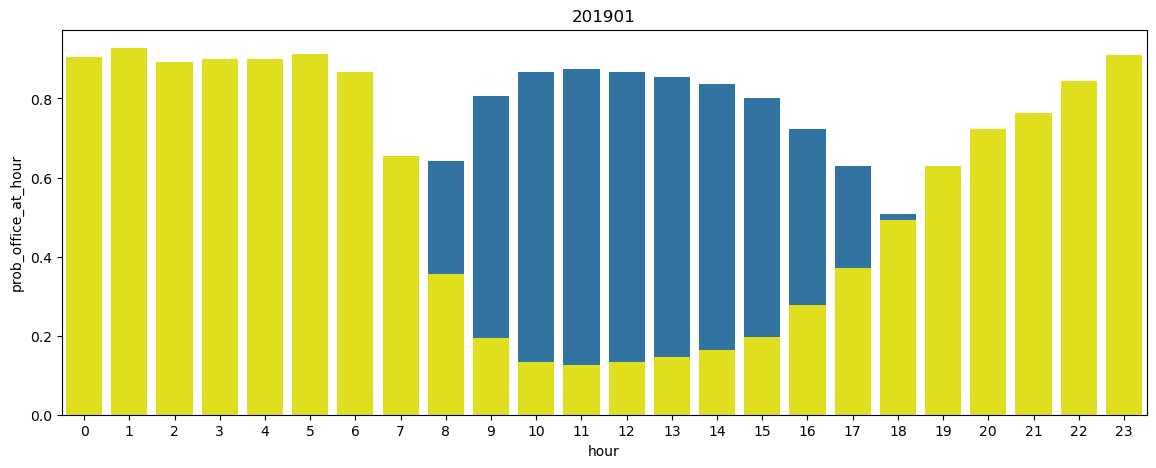

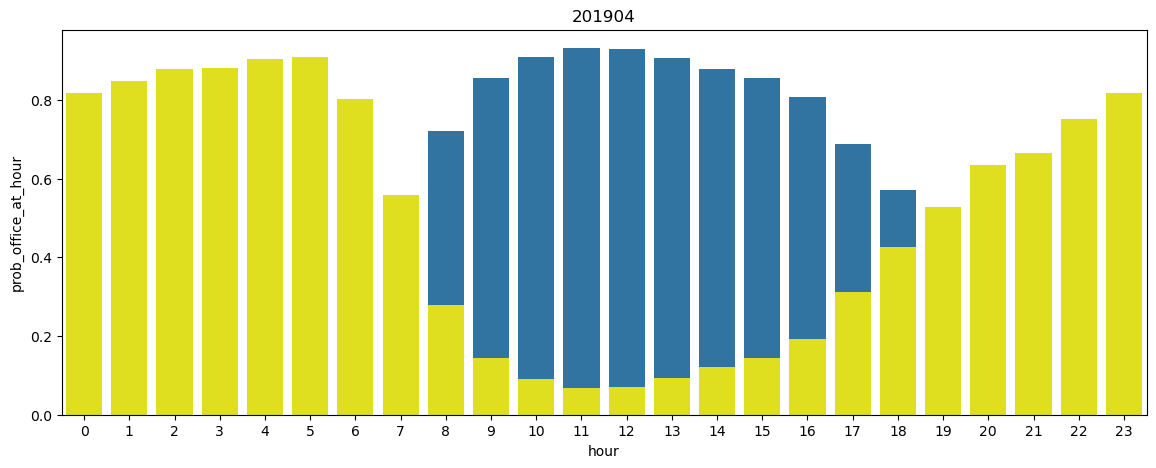

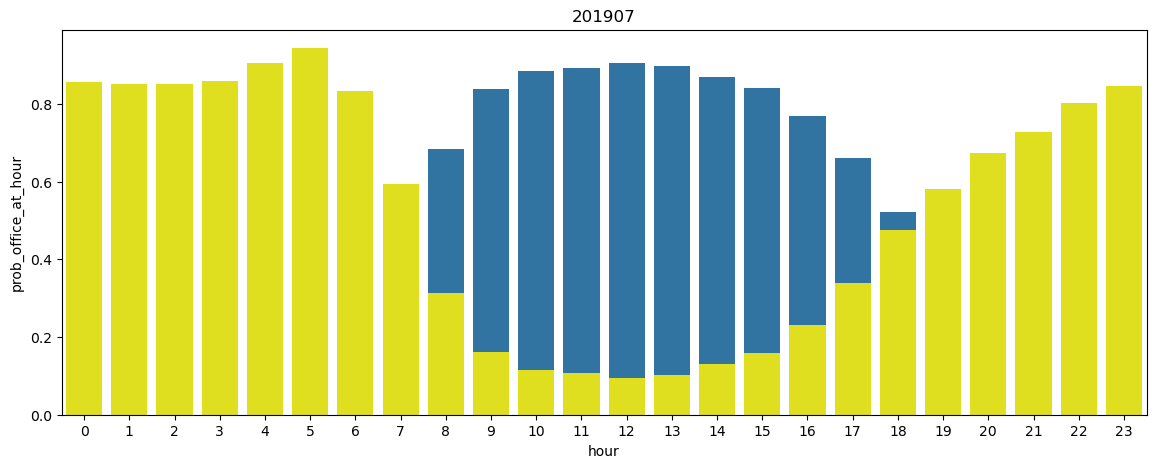

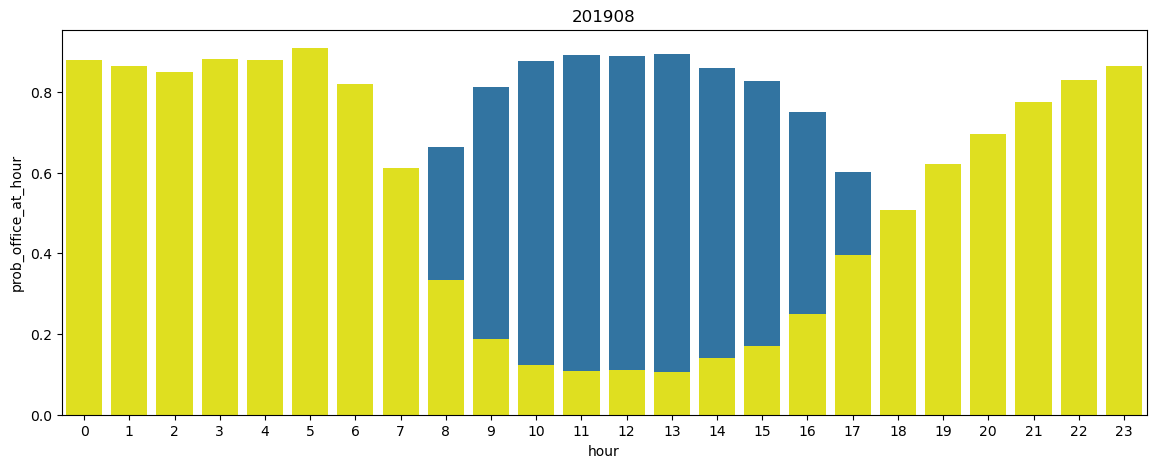

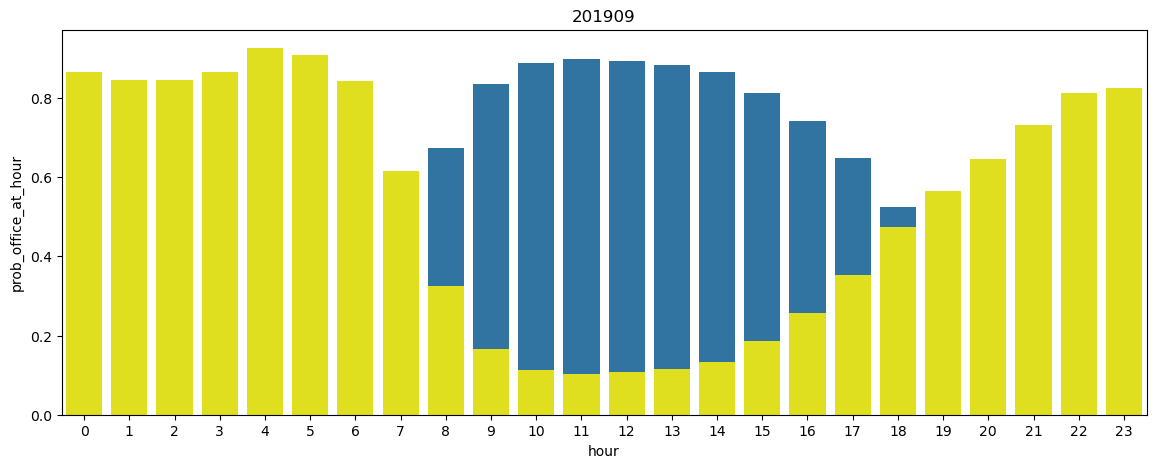

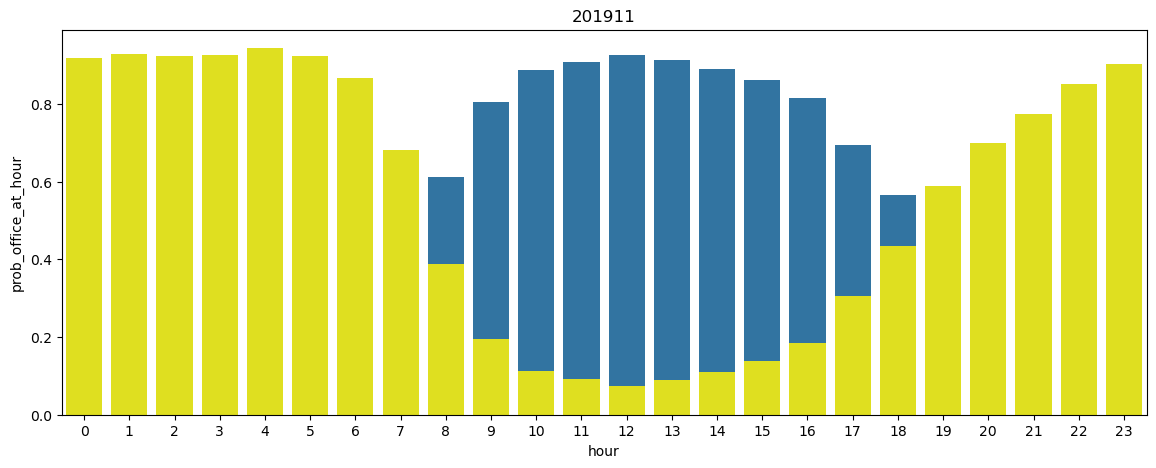

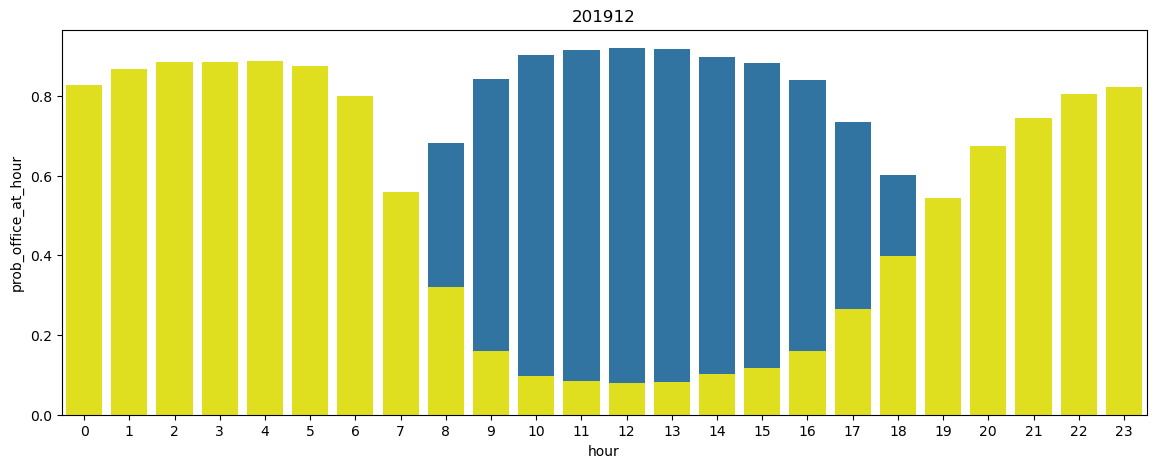

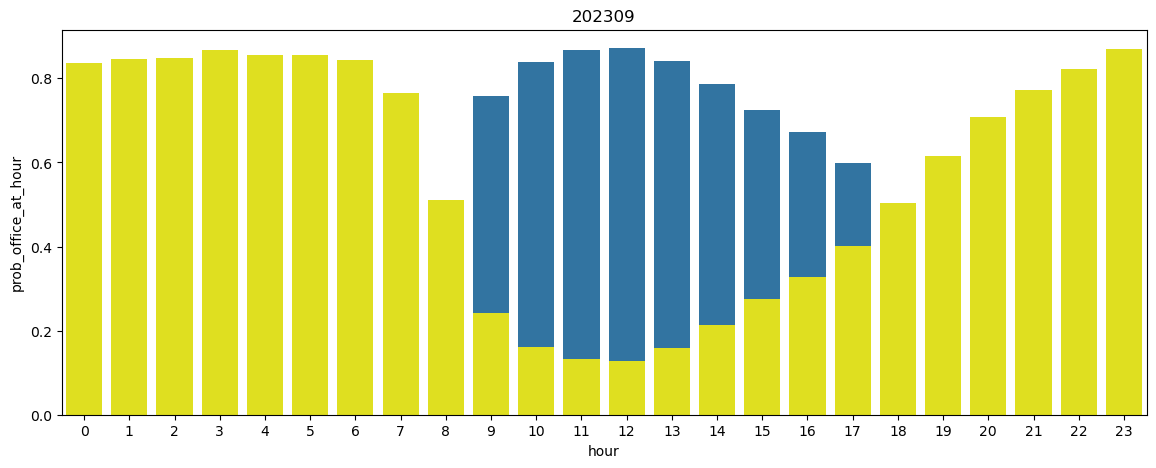

In [43]:
from matplotlib import pyplot as plt
import seaborn as sn

for MONTH in months:
    if len(df_prob_full[df_prob_full.month == MONTH]) > 0:
        fig, axs = plt.subplots(1, 1, figsize=(14, 5))
        sn.barplot(
            data=df_prob_full[df_prob_full.month == MONTH]
            .groupby("hour")["prob_office_at_hour"]
            .mean()
            .reset_index(),
            x="hour",
            y="prob_office_at_hour",
            ax=axs,
        )
        sn.barplot(
            data=df_prob_full[df_prob_full.month == MONTH]
            .groupby("hour")["prob_home_at_hour"]
            .mean()
            .reset_index(),
            x="hour",
            y="prob_home_at_hour",
            ax=axs,
            color="yellow",
        )
        plt.title(MONTH)
        plt.show()

In [46]:
df_hours = (
    df_hours
    .merge(
        df_prob_full[
            [
                "identifier",
                "month",
                "hour",
                "flag_weekend",
                "expected_prob_office_hour",
                "prob_home_at_hour",
                "prob_office_at_hour",
            ]
        ],
        on=["identifier", "month", "hour", "flag_weekend"],
        how="left",
    )
    .fillna(0)
)

In [48]:
# 1st approach. Based on remote work probability
df_hours["remote_work_probability"] = (
    (~df_hours["office_day"])
    * df_hours["expected_prob_office_hour"]
    * df_hours["flag_home_geohash"]
)
# 2nd approach. Based on comparing probability for home and office
df_hours["flag_remote_work_comparison"] = (
    (~df_hours["office_day"])
    * (df_hours["prob_home_at_hour"] < df_hours["prob_office_at_hour"])
    * df_hours["flag_home_geohash"]
)

In [ ]:
# df_hours = df_hours.drop("flag_remote_work", axis=1)

In [370]:
# df_hours.groupby(["identifier", "month", "date"])[
#     "flag_remote_work"
# ].max().groupby(["identifier", "month"]).sum() / df_hours[
#     ~df_hours.flag_weekend
# ].groupby(
#     ["identifier", "month"]
# )[
#     "date"
# ].nunique()

In [49]:
df_days_remote = (
    df_hours.groupby(["identifier", "month", "date"])[
        ["remote_work_probability", "flag_remote_work_comparison"]
    ]
    .max()
    .reset_index()
)
df_days_remote["flag_remote_work_min_prob"] = (
    df_days_remote["remote_work_probability"] >= 0.3
)

In [51]:
df_hours["flag_work_hour"] = (~df_hours["flag_weekend"]) & (
    df_hours["hour"].apply(lambda x: (x <= 20) & (x >= 8))
)
df_hours["flag_work_hours_day"] = (
    df_hours.groupby(["identifier", "date"])["flag_work_hour"].transform("sum") > 0
)

In [52]:
df_days_remote = df_days_remote.merge(df_hours
            .groupby(["identifier", "month","date"])['flag_work_hours_day'].max(), on = ["identifier", "month","date"])

In [ ]:
# df_days_remote = df_days_remote.merge(
#     df_hours[~df_hours.flag_weekend]
#     .groupby(["identifier", "month"])["date"]
#     .nunique()
#     .rename("nonweekends_count"),
#     on=["identifier", "month"],
# )

In [53]:
df_monthly_remote = (
    df_days_remote.groupby(["identifier","month"])[
        [
            "flag_remote_work_min_prob",
            "remote_work_probability",
            "flag_remote_work_comparison",
        ]
    ]
    .mean()
    .join(
        (
            df_days_remote.groupby(["identifier", "month"])[
                "flag_remote_work_comparison"
            ].sum()
            /df_days_remote.groupby(["identifier", "month"])['flag_work_hours_day']
            .sum()
        ).rename("share_remote_work_comparison_days")
    )
    .join(
        (
            df_days_remote.groupby(["identifier", "month"])[
                "flag_remote_work_min_prob"
            ].sum()
            /df_days_remote.groupby(["identifier", "month"])['flag_work_hours_day']
            .sum()
        ).rename("share_remote_work_min_prob_days")
    )
)

In [54]:
df_monthly_remote = df_monthly_remote.sort_values('month')

In [56]:
df_monthly_remote = df_monthly_remote.reset_index()

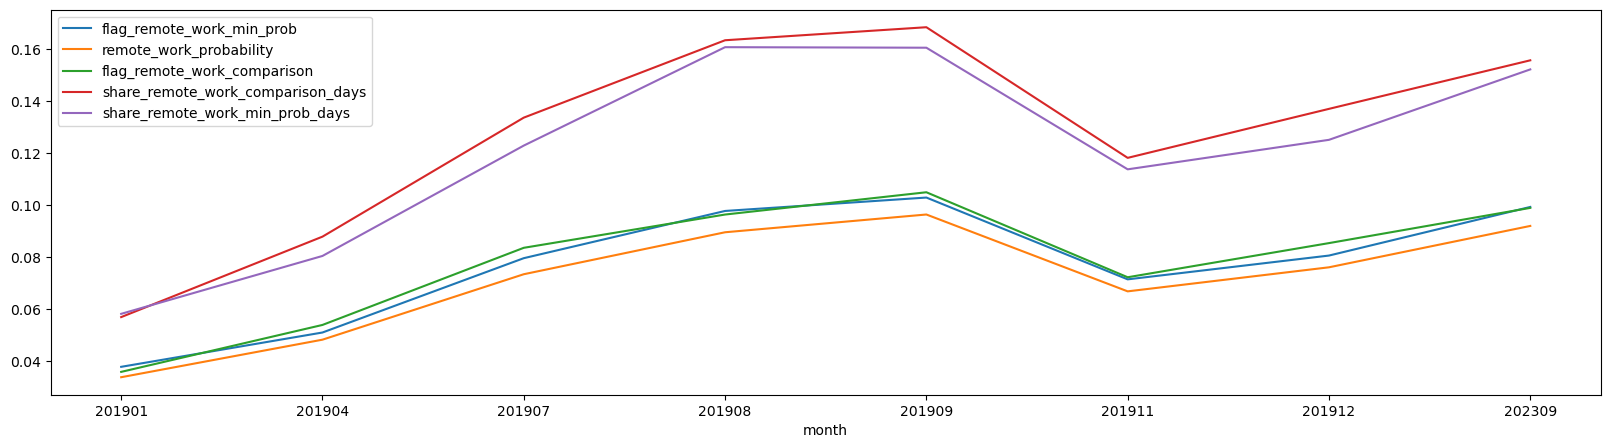

In [57]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
df_monthly_remote.groupby('month')[['flag_remote_work_min_prob',
       'remote_work_probability', 'flag_remote_work_comparison',
       'share_remote_work_comparison_days', 'share_remote_work_min_prob_days']].mean().plot(ax=ax);

In [421]:
df_monthly_remote.loc[df_monthly_remote.month=='202007']

,identifier,month,flag_remote_work_min_prob,remote_work_probability,flag_remote_work_comparison,share_remote_work_comparison_days,share_remote_work_min_prob_days
2665,375b744f-437f-44a2-9eb6-ab38481c2099,202007,0.117647,0.117647,0.117647,0.142857,0.142857
2666,bfd3d409-9656-480f-8a61-59cd33d3e44c,202007,0.040000,0.040000,0.080000,0.105263,0.052632
2667,caf568e0-db0d-48a1-a78c-f912ea4d2166,202007,0.045455,0.045455,0.045455,0.058824,0.058824
2668,9d5dbfd5-4765-4ce6-85b7-82bc28b04b68,202007,0.142857,0.100000,0.142857,0.200000,0.200000
2669,77d3bbea-cb9d-4150-9134-48008f185c6e,202007,0.160000,0.106667,0.080000,0.111111,0.222222
...,...,...,...,...,...,...,...
3664,fb8a062a-914e-4782-880a-4473fe2a8bdf,202007,0.000000,0.000000,0.000000,0.000000,0.000000
3665,5aca2aca-cef4-4a36-bed5-a13defed09a3,202007,0.090909,0.090909,0.090909,0.125000,0.125000
3666,d872e83d-182a-4618-98a0-b3e0a6e377a5,202007,0.055556,0.027778,0.000000,0.000000,0.083333
3667,5a86990a-eb6e-45a1-9c41-5577b06a5d52,202007,0.250000,0.222222,0.250000,0.333333,0.333333


In [425]:
df_days_remote[df_days_remote.identifier=='375b744f-437f-44a2-9eb6-ab38481c2099']

,identifier,month,date,remote_work_probability,flag_remote_work_comparison,flag_remote_work_min_prob
71990,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-02,1.0,True,True
71991,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-04,0.0,False,False
71992,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-05,0.0,False,False
71993,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-06,0.0,False,False
71994,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-07,0.0,False,False
...,...,...,...,...,...,...
72113,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-18,0.0,False,False
72114,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-19,0.0,False,False
72115,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-20,0.0,False,False
72116,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-21,0.0,False,False


## Merge with original day types

In [58]:
df_user_days = (
    df_hours.groupby(["identifier", "date", "month"])[
        ["flag_work_hours_day", "flag_weekend", "office_day"]
    ]
    .mean()
    .reset_index()
)
df_user_days = df_user_days.merge(
    df_days_remote, on=["identifier", "month", "date"]
)

In [59]:
df_user_days["day_type"] = df_user_days[
    ['flag_remote_work_comparison',	'flag_remote_work_min_prob', "flag_weekend", "office_day"]
].apply(
    lambda r: (
        "office"
        if r["office_day"] == 1
        else (
            "remote"
            if (r["flag_remote_work_comparison"] > 0) and (not r["flag_weekend"])
            else ("weekend" if r["flag_weekend"] else "unknown")
        )
    ),
    axis=1,
)

In [60]:
df_days_types = (
    df_user_days.groupby(["month", "day_type"]).size().rename("day_count").reset_index()
)

In [61]:
df_days_types.day_type.value_counts()

day_type
office     8
remote     8
unknown    8
weekend    8
Name: count, dtype: int64

In [62]:
months = df_days_types["month"].unique()
day_types = df_days_types["day_type"].unique()

# Create a complete DataFrame with all combinations of months and day types
full_combinations = pd.MultiIndex.from_product(
    [months, day_types], names=["month", "day_type"]
)
full_df = pd.DataFrame(index=full_combinations).reset_index()
df_days_types_complete = full_df.merge(
    df_days_types, on=["month", "day_type"], how="left"
).fillna({"day_count": 0})

In [63]:
df_days_types_complete["day_count"] = df_days_types_complete["day_count"].astype(int)

In [64]:
# Exclude rows where day_type is 'Weekend'
filtered_df = df_days_types_complete[df_days_types_complete["day_type"] != "weekend"]

# Calculate the total day count per month (excluding 'Weekend')
filtered_df["month_total"] = filtered_df.groupby("month")["day_count"].transform("sum")

# Calculate the share of day counts for each row
filtered_df["share_of_day_counts"] = (
    filtered_df["day_count"] / filtered_df["month_total"]
)

# Drop the temporary 'month_total' column if not needed
filtered_df = filtered_df.drop(columns=["month_total"])

In [67]:
bad_months = []#filtered_df[(filtered_df.day_type=='unknown')&(filtered_df['share_of_day_counts']>0.32)]['month']

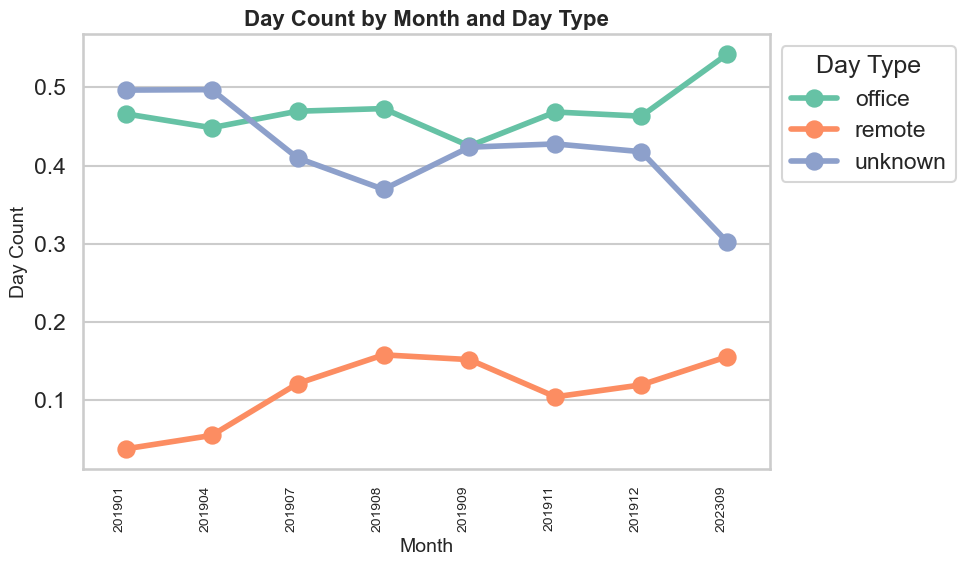

In [68]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set the style and context
sn.set_theme(style="whitegrid", context="talk")


# Create the point plot with enhancements
plt.figure(figsize=(10, 6))
plot = sn.pointplot(
    data=filtered_df[~filtered_df.month.isin(bad_months)],
    x="month",
    y="share_of_day_counts",
    hue="day_type",
    palette="Set2",  # Vibrant color palette
)

# Customize labels and title
plot.set_title("Day Count by Month and Day Type", fontsize=16, weight="bold")
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Day Count", fontsize=14)

# Rotate x-axis labels for better readability
plot.set_xticklabels(
    plot.get_xticklabels(), rotation="vertical", horizontalalignment="right", fontsize=10
)

# Add legend and improve its placement
plot.legend(title="Day Type", loc="upper left", bbox_to_anchor=(1, 1))


# Display the plot
plt.tight_layout()
plt.show()

In [465]:
df_monthly_remote[~df_monthly_remote.month.isin(bad_months)].columns

Index(['identifier', 'month', 'flag_remote_work_min_prob',
       'remote_work_probability', 'flag_remote_work_comparison',
       'share_remote_work_comparison_days', 'share_remote_work_min_prob_days'],
      dtype='object')

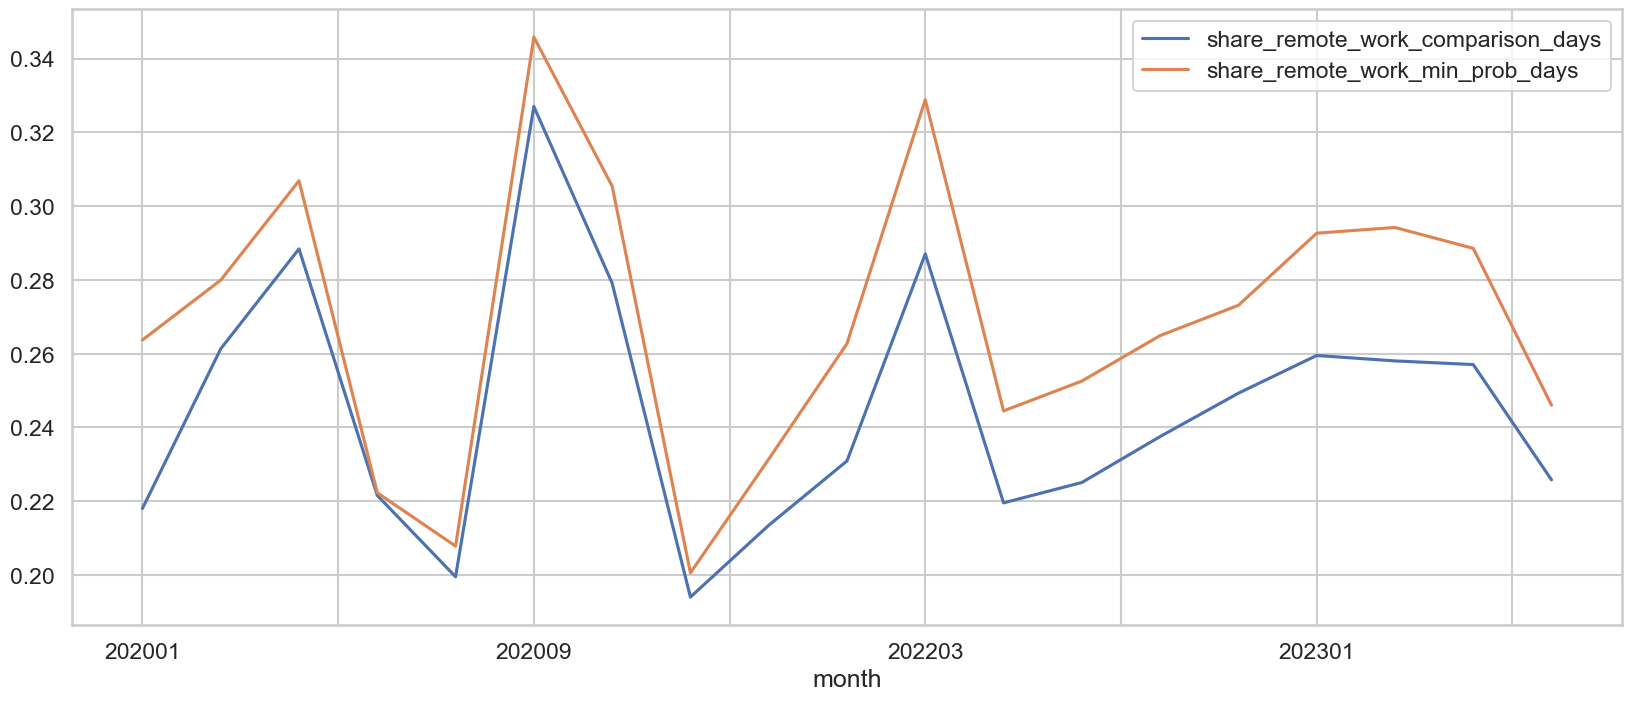

In [564]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
df_monthly_remote[~df_monthly_remote.month.isin(bad_months)].groupby('month')[[
       'share_remote_work_comparison_days', 'share_remote_work_min_prob_days']].mean().plot(ax=ax);

In [469]:
df_monthly_remote[df_monthly_remote.month=='202106'].head(2)

,identifier,month,flag_remote_work_min_prob,remote_work_probability,flag_remote_work_comparison,share_remote_work_comparison_days,share_remote_work_min_prob_days
8054,fe452ce8-af4a-47e3-ad7c-546c609dd03f,202106,0.000000,0.000000,0.000000,0.000000,0.000000
8055,fff83b7d-9370-4d8a-bb58-d0f40b772257,202106,0.058824,0.058824,0.058824,0.071429,0.071429


In [478]:
df_hours.columns

Index(['identifier', 'identifier_type', 'timestamp', 'local_date_time',
       'province', 'classification', 'duration_seconds', 'centroid_latitude',
       'centroid_longitude', 'bump_count', 'potential_start_time',
       'potential_end_time', 'month', 'the_geom', 'frequency',
       'duration_hours', 'geohash', 'date', 'start_date_time', 'end_date_time',
       'flag_night', 'flag_work_hours', 'geohash_home', 'geohash_work',
       'geometry_work', 'distance_work', 'flag_work_geohash', 'geometry_home',
       'distance_home', 'flag_home_geohash', 'flag_type_loc_new',
       'hours_in_interval', 'hour', 'flag_weekend', 'work_location_hours',
       'office_day', 'flag_work_hour', 'flag_work_hours_day',
       'remote_work_probability', 'flag_remote_work_comparison',
       'expected_prob_office_hour', 'prob_home_at_hour',
       'prob_office_at_hour'],
      dtype='object')

In [ ]:
df_hours[(df_hours.identifier == 'fff83b7d-9370-4d8a-bb58-d0f40b772257')&(df_hours.month=='202107')&(~df_hours.office_day)] [[
        "month",
        "date",
        "hour",
        "office_day",
        "flag_weekend",
        "flag_home_geohash",
        "flag_work_geohash",
        'prob_home_at_hour',
       'prob_office_at_hour',
        'remote_work_probability', 'flag_remote_work_comparison'
    ]
].sort_values(
    ["date", "hour"]).head(50)